## Wheel encoder error

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
CSV_FILE = "tachometer_data.csv"
WHEEL_RADIUS = 0.0325

### 1. Import the data and calculate the errors

In [3]:
# Read the data
data = pd.read_csv(CSV_FILE)
# convert the tachometer measurements to linear velocities
data.insert(2, "tachometer velocities", data["tachometer rpms"] / 60 * WHEEL_RADIUS * 2 * np.pi)
# calculate the errors
data.insert(3, "errors", data["encoder velocities"] - data["tachometer velocities"])
data

,tachometer rpms,encoder velocities,tachometer velocities,errors
0,30.3,0.106266,0.103123,0.003143
1,30.3,0.106965,0.103123,0.003843
2,30.3,0.104976,0.103123,0.001853
3,30.8,0.109008,0.104824,0.004184
4,30.8,0.106983,0.104824,0.002158
5,48.5,0.169738,0.165065,0.004674
6,48.5,0.168859,0.165065,0.003794
7,48.5,0.167479,0.165065,0.002415
8,48.7,0.167566,0.165745,0.001821
9,48.7,0.169558,0.165745,0.003812


### 2. Find the mean and variance

The mean is used to calibrate the velocity and is modelled as a function of the measured velocity. This results in a constant calibration factor.

The variance is a constant value and sent with the velocity reading to the extended Kalman filter used downstream

In [4]:
from scipy.optimize import least_squares

In [5]:
"""Error as function of the measured velocity"""


def fun_error(bias, velocity, error):
    """Model the error as function of the wheel encoder velocity, where `bias` is the calibration factor"""
    return bias * velocity - error


# the wheel encoder velocties and errors
encoder_vels, errors = data["encoder velocities"].to_numpy(), data["errors"].to_numpy()

bias0 = 0.001
res = least_squares(fun_error, bias0, args=(encoder_vels, errors))
opt_bias = res.x.squeeze()  # the optimal calibration factor

# calibrate the wheel encoder velocities ...
calibrated_encoder_vels = errors - opt_bias * encoder_vels


def calc_variance(values):
    return np.sum(values**2) / (len(values) - 1)


# ... and calculate the variance over them
variance = calc_variance(calibrated_encoder_vels)
std_dev = np.sqrt(variance)

print(f"Bias (or calibration) factor = {opt_bias}")
print(f"Variance of the calibrated (unbiased) measurements = {variance}")

Bias (or calibration) factor = 0.024875459797181865
Variance of the calibrated (unbiased) measurements = 3.0058265358206346e-06


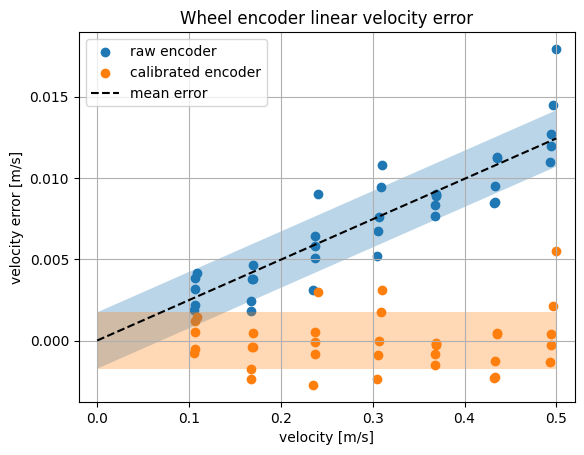

In [10]:
fig, ax = plt.subplots(1, 1)

ax.scatter(encoder_vels, errors, label="raw encoder")
ax.scatter(encoder_vels, calibrated_encoder_vels, label="calibrated encoder")

line_x, line_y = np.vstack([[0, 0], [encoder_vels.max(), opt_bias * encoder_vels.max()]]).T
ax.plot(line_x, line_y, "k--", label="mean error")
ax.fill_between(line_x, line_y - std_dev, line_y + std_dev, alpha=0.3, facecolor="tab:blue")
ax.fill_between(line_x, -np.full_like(line_y, std_dev), np.full_like(line_y, std_dev), alpha=0.3, facecolor="tab:orange")
ax.set_title("Wheel encoder linear velocity error")
ax.set_xlabel("velocity [m/s]")
ax.set_ylabel("velocity error [m/s]")
ax.set_xlim(-0.02, 0.52)
ax.grid()
ax.legend()

plt.savefig("wheel_encoders_fit.png", bbox_inches="tight")
plt.savefig("wheel_encoders_fit.pdf", bbox_inches="tight")
plt.show()